<a href="https://colab.research.google.com/github/ngocanhhoangklu/Walmart-Sales-Forecast/blob/main/walmast_sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Install Required Packages & Setup

!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels pmdarima opendatasets prophet -q

print(" All packages installed successfully!")

 All packages installed successfully!


In [ ]:
# CELL 2: Download Walmart Dataset from Kaggle

import opendatasets as od

# Download the Walmart Sales Forecast dataset
# You'll be prompted to enter your Kaggle username and API key
# Get your API key from: https://www.kaggle.com/settings → Create New API Token

dataset_url = 'https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast'
od.download(dataset_url)

print(" Walmart dataset downloaded successfully!")


Skipping, found downloaded files in "./walmart-sales-forecast" (use force=True to force download)
 Walmart dataset downloaded successfully!


In [ ]:
# CELL 3: Import Libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series and forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [ ]:
# CELL 4: Load and Explore the Walmart Dataset

# Load all three Walmart data files
train_df = pd.read_csv('walmart-sales-forecast/train.csv')
stores_df = pd.read_csv('walmart-sales-forecast/stores.csv')
features_df = pd.read_csv('walmart-sales-forecast/features.csv')

print("="*80)
print("📊 WALMART DATASET OVERVIEW")
print("="*80)

print("\n📋 TRAIN DATA (Sales by Store & Department):")
print(f"   Shape: {train_df.shape}")
print(f"   Columns: {train_df.columns.tolist()}")
print(train_df.head())

print("\n📋 STORES DATA (Store Information):")
print(f"   Shape: {stores_df.shape}")
print(f"   Columns: {stores_df.columns.tolist()}")
print(stores_df.head())

print("\n📋 FEATURES DATA (External Factors):")
print(f"   Shape: {features_df.shape}")
print(f"   Columns: {features_df.columns.tolist()}")
print(features_df.head())

# Check for missing values
print("\n❓ Missing Values in Train Data:")
print(train_df.isnull().sum())
print("\n❓ Missing Values in Features Data:")
print(features_df.isnull().sum())


📊 WALMART DATASET OVERVIEW

📋 TRAIN DATA (Sales by Store & Department):
   Shape: (421570, 5)
   Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

📋 STORES DATA (Store Information):
   Shape: (45, 3)
   Columns: ['Store', 'Type', 'Size']
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

📋 FEATURES DATA (External Factors):
   Shape: (8190, 12)
   Columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010

In [ ]:
# CELL 5: Data Preprocessing & Merging

# Convert date columns
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Merge all datasets
df = train_df.merge(stores_df, on='Store', how='left')
df = df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# Fill missing markdown values with 0 (no markdown)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Fill other missing values
df['CPI'] = df['CPI'].fillna(df['CPI'].median())
df['Unemployment'] = df['Unemployment'].fillna(df['Unemployment'].median())

# Create total markdown column
df['Total_MarkDown'] = df[markdown_cols].sum(axis=1) if all(col in df.columns for col in markdown_cols) else 0

# Sort by date
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

print(" Data merged and preprocessed successfully!")
print(f" Combined Dataset Shape: {df.shape}")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f" Number of Stores: {df['Store'].nunique()}")
print(f" Number of Departments: {df['Dept'].nunique()}")


 Data merged and preprocessed successfully!
 Combined Dataset Shape: (421570, 17)
Date Range: 2010-02-05 to 2012-10-26
 Number of Stores: 45
 Number of Departments: 81


In [ ]:
# CELL 6: Aggregate Weekly Sales - Warehouse Context


# Aggregate weekly sales across all stores and departments
# This represents total "outgoing" inventory (sales = items leaving warehouse)
weekly_total = df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'IsHoliday': 'first',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Total_MarkDown': 'sum'
}).reset_index()

weekly_total.columns = ['Date', 'Total_Sales', 'IsHoliday', 'Avg_Temperature',
                        'Avg_Fuel_Price', 'Avg_CPI', 'Avg_Unemployment', 'Total_MarkDown']

# For warehouse context: Sales = Outgoing inventory
# Simulate incoming based on sales patterns (replenishment)
np.random.seed(42)
weekly_total['Outgoing'] = weekly_total['Total_Sales'] / 1e6  # Scale down for readability
weekly_total['Incoming'] = (weekly_total['Outgoing'] * 1.05 +
                            np.random.normal(2, 0.5, len(weekly_total)))
weekly_total['Incoming'] = weekly_total['Incoming'].clip(lower=0)

# Calculate net weekly change
weekly_total['Net_Change'] = weekly_total['Incoming'] - weekly_total['Outgoing']

# Calculate cumulative inventory (warehouse stock level)
initial_inventory = 50  # Starting inventory in millions
weekly_total['Inventory_Level'] = initial_inventory + weekly_total['Net_Change'].cumsum()
weekly_total['Inventory_Level'] = weekly_total['Inventory_Level'].clip(lower=10)

# Add time features
weekly_total['Week'] = weekly_total['Date'].dt.isocalendar().week
weekly_total['Month'] = weekly_total['Date'].dt.month
weekly_total['Year'] = weekly_total['Date'].dt.year
weekly_total['Month_Name'] = weekly_total['Date'].dt.month_name()

# Rolling averages
weekly_total['Rolling_Avg_4W'] = weekly_total['Total_Sales'].rolling(window=4, min_periods=1).mean()
weekly_total['Rolling_Avg_8W'] = weekly_total['Total_Sales'].rolling(window=8, min_periods=1).mean()

print("Weekly aggregation completed!")
print(f" Total weeks of data: {len(weekly_total)}")
print(f" Average weekly sales: ${weekly_total['Total_Sales'].mean():,.0f}")
print(f" Current inventory level: {weekly_total['Inventory_Level'].iloc[-1]:.2f}M units")

# Display sample
print("\n Sample of Aggregated Data:")
print(weekly_total.head(10))

Weekly aggregation completed!
 Total weeks of data: 143
 Average weekly sales: $47,113,419
 Current inventory level: 666.94M units

 Sample of Aggregated Data:
        Date  Total_Sales  IsHoliday  Avg_Temperature  Avg_Fuel_Price  \
0 2010-02-05  49750740.50      False        33.277942        2.717869   
1 2010-02-12  48336677.63       True        33.361810        2.696102   
2 2010-02-19  48276993.78      False        37.038310        2.673666   
3 2010-02-26  43968571.13      False        38.629563        2.685642   
4 2010-03-05  46871470.30      False        42.373998        2.731816   
5 2010-03-12  45925396.51      False        46.967143        2.774452   
6 2010-03-19  44988974.64      False        49.481019        2.816063   
7 2010-03-26  44133961.05      False        47.979325        2.823610   
8 2010-04-02  50423831.26      False        52.587887        2.825453   
9 2010-04-09  47365290.44      False        58.098526        2.852423   

      Avg_CPI  Avg_Unemployment  Tot

In [ ]:
# CELL 7: Store-Level Analysis


# Aggregate by store
store_summary = df.groupby('Store').agg({
    'Weekly_Sales': ['sum', 'mean', 'std'],
    'Type': 'first',
    'Size': 'first'
}).reset_index()

store_summary.columns = ['Store', 'Total_Sales', 'Avg_Weekly_Sales', 'Sales_Std', 'Type', 'Size']
store_summary = store_summary.sort_values('Total_Sales', ascending=False)

print("\n🏪 TOP 10 PERFORMING STORES:")
print(store_summary.head(10).to_string(index=False))

print("\n🏪 BOTTOM 5 PERFORMING STORES:")
print(store_summary.tail(5).to_string(index=False))

# Store type analysis
type_analysis = df.groupby('Type').agg({
    'Weekly_Sales': ['sum', 'mean', 'count'],
    'Size': 'mean'
}).reset_index()
type_analysis.columns = ['Type', 'Total_Sales', 'Avg_Weekly_Sales', 'Record_Count', 'Avg_Size']

print("\n SALES BY STORE TYPE:")
print(type_analysis.to_string(index=False))


🏪 TOP 10 PERFORMING STORES:
 Store  Total_Sales  Avg_Weekly_Sales    Sales_Std Type   Size
    20 301397792.46      29508.301592 35661.530620    A 203742
     4 299543953.38      29161.210415 34583.677814    A 205863
    14 288999911.34      28784.851727 36911.116744    A 200898
    13 286517703.80      27355.136891 33853.474638    A 219622
     2 275382440.98      26898.070031 33077.612059    A 202307
    10 271617713.89      26332.303819 32133.006264    B 126512
    27 253855916.88      24826.984536 29718.919095    A 204184
     6 223756130.64      21913.243624 23633.427075    A 202505
     1 222402808.85      21710.543621 27748.945511    A 151315
    39 207445542.47      21000.763562 25373.751512    A 184109

🏪 BOTTOM 5 PERFORMING STORES:
 Store  Total_Sales  Avg_Weekly_Sales    Sales_Std Type  Size
    38  55159626.42       7492.478460 12733.356273    C 39690
    36  53412214.97       8584.412563 12995.813451    A 39910
     5  45475688.90       5053.415813  8068.221050    B 34875

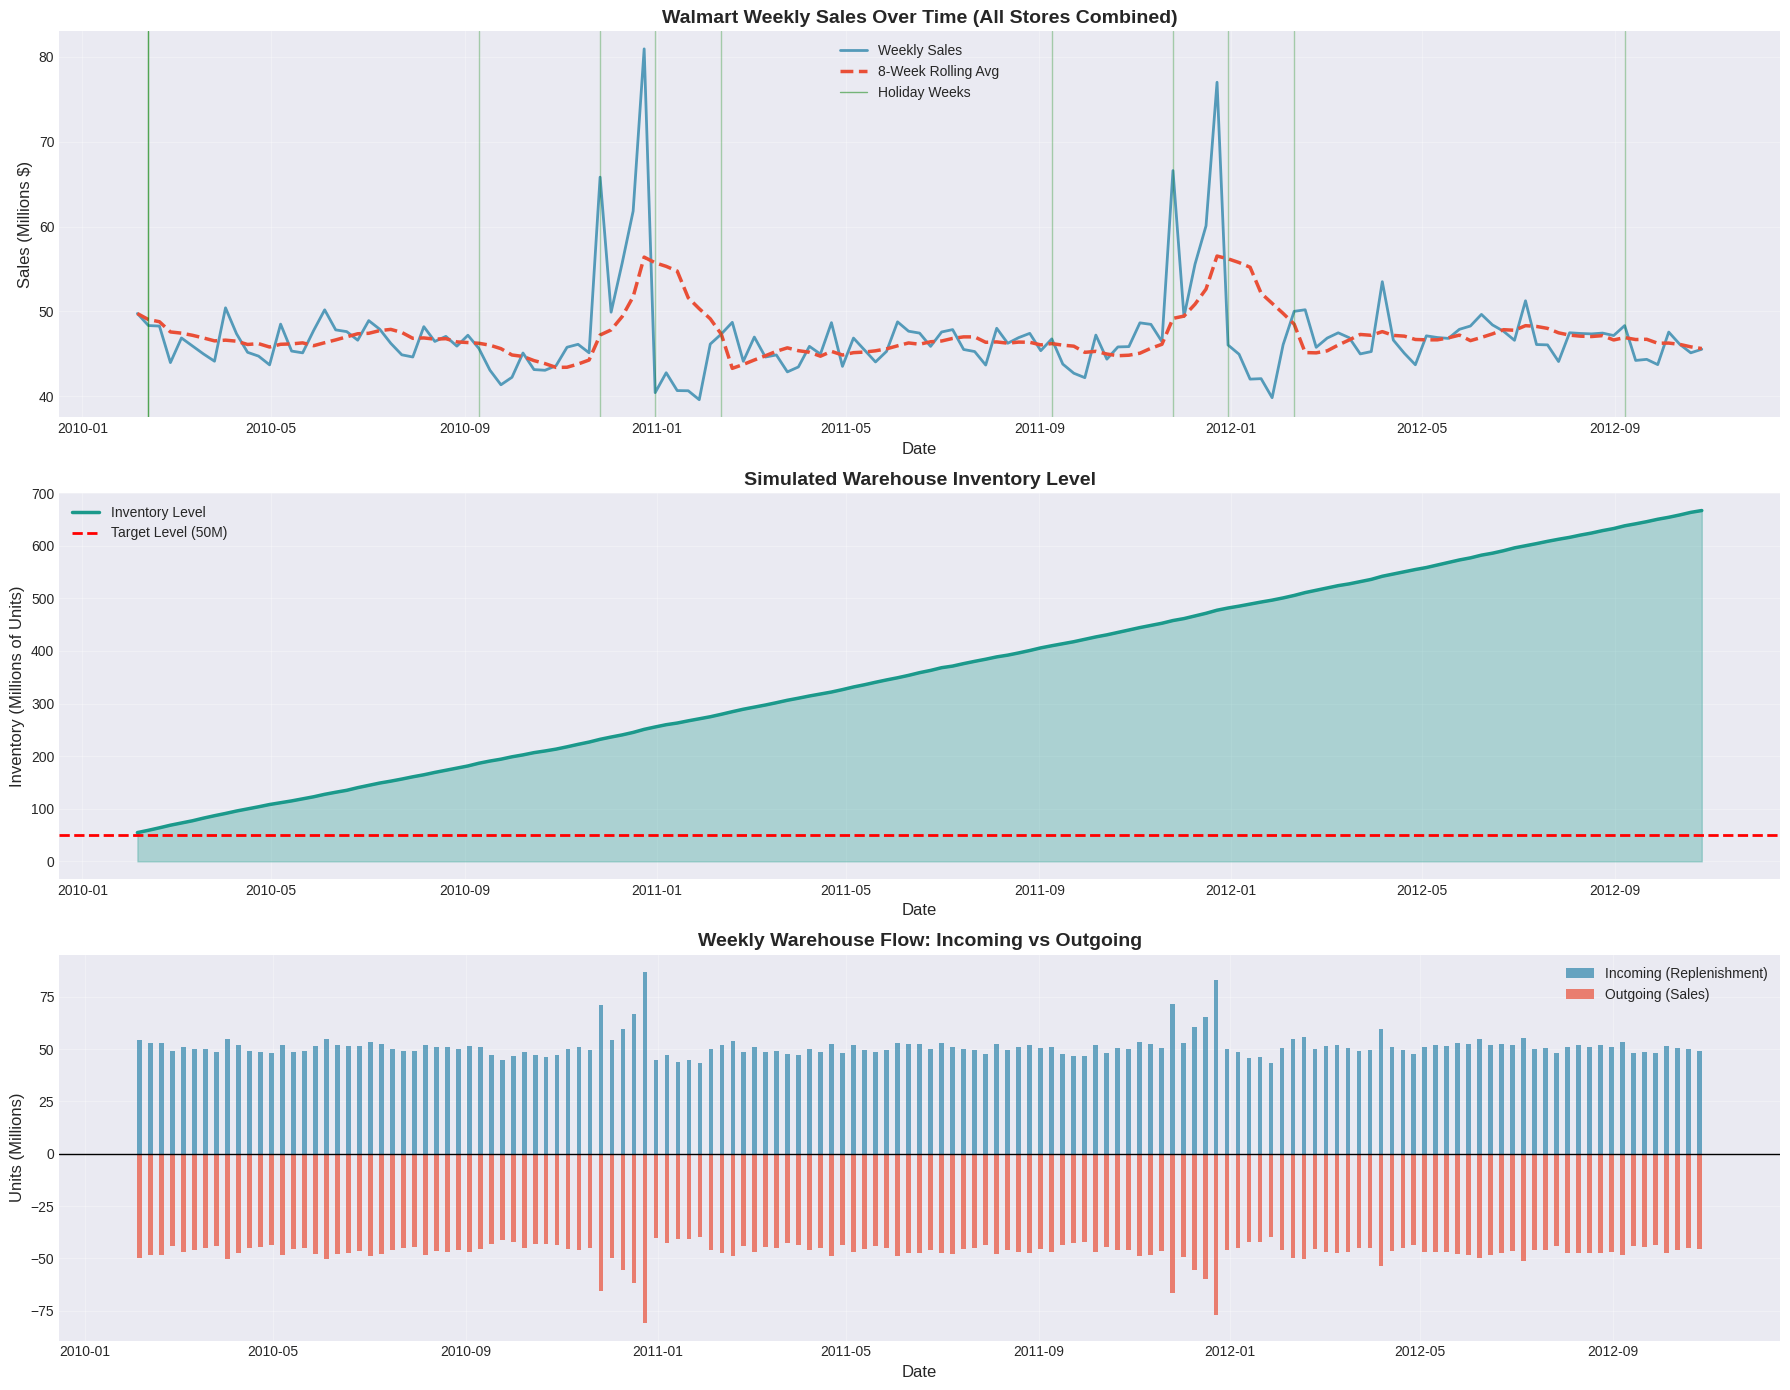

 Time series visualization saved: walmart_time_series_analysis.png


In [ ]:
# CELL 8: Exploratory Data Analysis - Time Series

fig, axes = plt.subplots(3, 1, figsize=(18, 14))

# Plot 1: Weekly Sales Over Time
axes[0].plot(weekly_total['Date'], weekly_total['Total_Sales']/1e6,
             label='Weekly Sales', color='#2E86AB', linewidth=2, alpha=0.8)
axes[0].plot(weekly_total['Date'], weekly_total['Rolling_Avg_8W']/1e6,
             label='8-Week Rolling Avg', color='#E94F37', linewidth=2.5, linestyle='--')

# Highlight holidays
holiday_dates = weekly_total[weekly_total['IsHoliday'] == True]['Date']
for hd in holiday_dates:
    axes[0].axvline(x=hd, color='green', alpha=0.3, linewidth=1)
axes[0].axvline(x=holiday_dates.iloc[0] if len(holiday_dates) > 0 else weekly_total['Date'].iloc[0],
                color='green', alpha=0.5, linewidth=1, label='Holiday Weeks')

axes[0].set_title('Walmart Weekly Sales Over Time (All Stores Combined)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Sales (Millions $)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Inventory Level (Warehouse Context)
axes[1].plot(weekly_total['Date'], weekly_total['Inventory_Level'],
             label='Inventory Level', color='#1B998B', linewidth=2.5)
axes[1].fill_between(weekly_total['Date'], 0, weekly_total['Inventory_Level'],
                     alpha=0.3, color='#1B998B')
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Target Level (50M)')
axes[1].set_title('Simulated Warehouse Inventory Level', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Inventory (Millions of Units)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Plot 3: Incoming vs Outgoing (Warehouse Flow)
width = 3
axes[2].bar(weekly_total['Date'], weekly_total['Incoming'], width=width,
            label='Incoming (Replenishment)', alpha=0.7, color='#2E86AB')
axes[2].bar(weekly_total['Date'], -weekly_total['Outgoing'], width=width,
            label='Outgoing (Sales)', alpha=0.7, color='#E94F37')
axes[2].axhline(y=0, color='black', linewidth=1)
axes[2].set_title('Weekly Warehouse Flow: Incoming vs Outgoing', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Units (Millions)', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walmart_time_series_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Time series visualization saved: walmart_time_series_analysis.png")


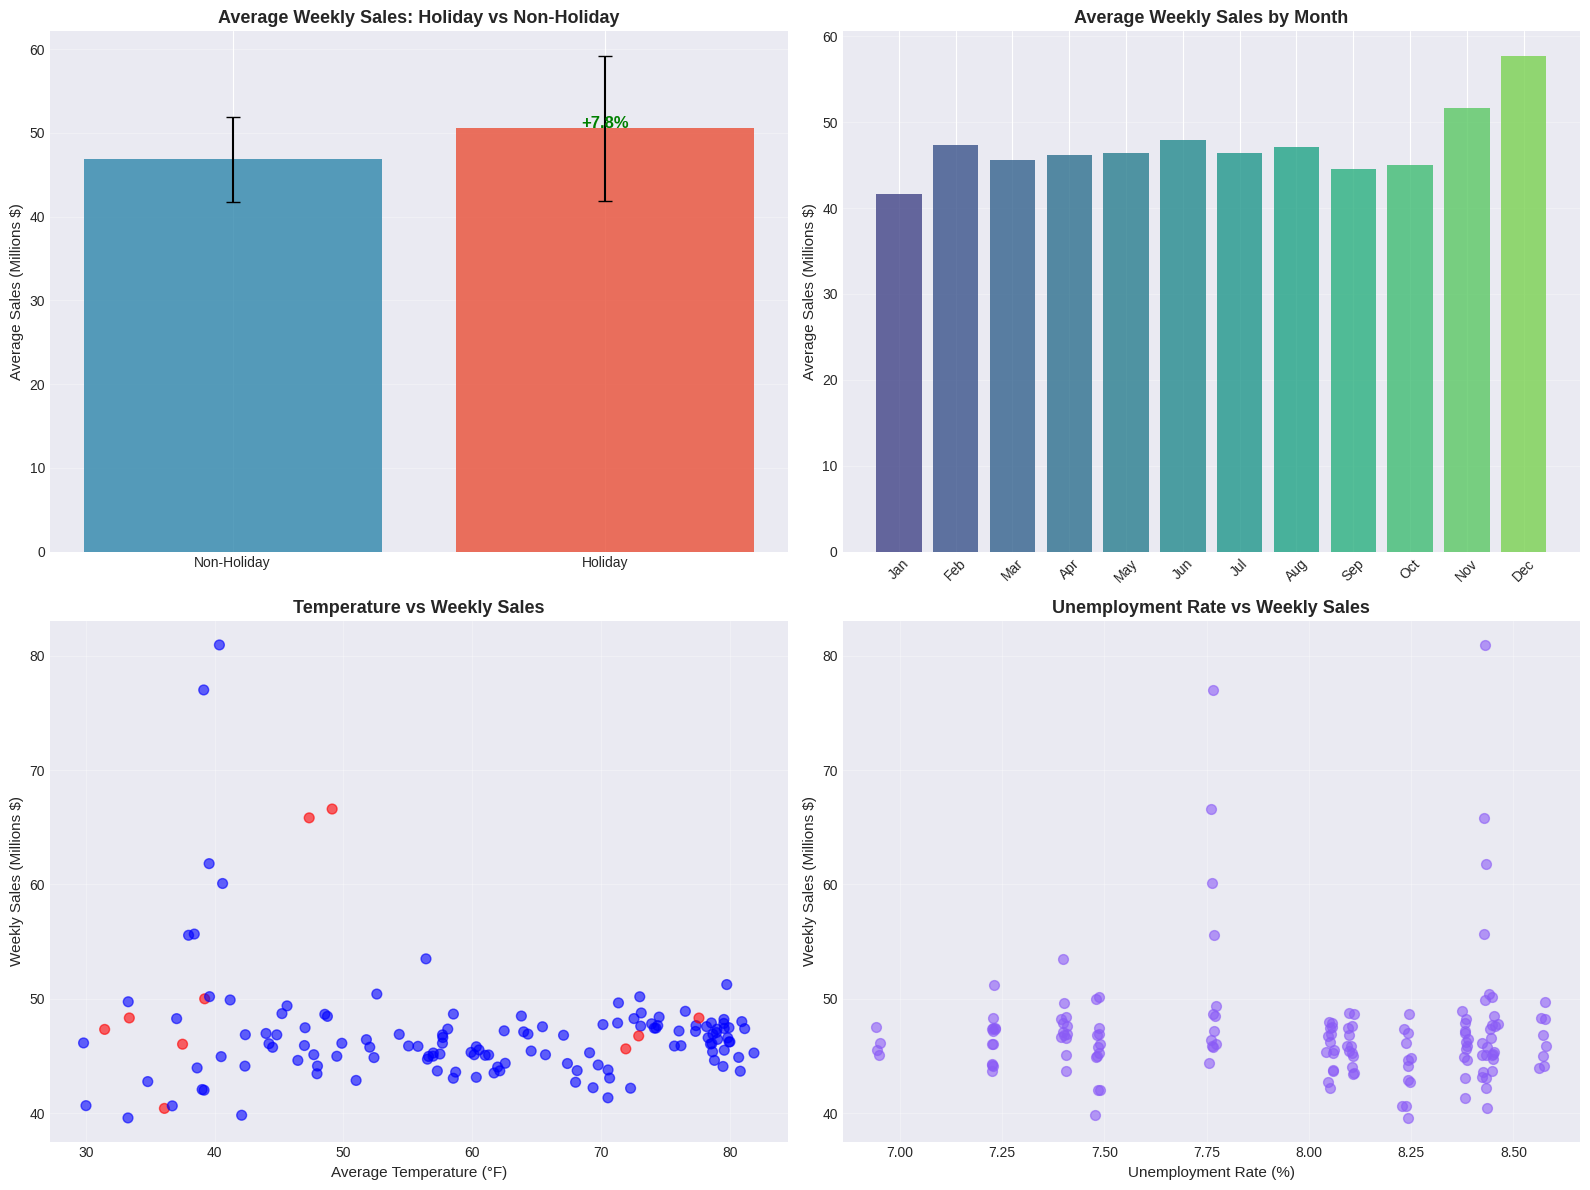

✅ Seasonal analysis saved: walmart_seasonal_analysis.png

 KEY INSIGHTS:
   Holiday weeks average: $50,529,955 (+7.8% vs non-holiday)
   Best month: December ($57.68M avg)
   Worst month: January ($41.57M avg)


In [ ]:
# CELL 9: Holiday & Seasonal Analysis

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Holiday vs Non-Holiday Sales
holiday_comparison = weekly_total.groupby('IsHoliday')['Total_Sales'].agg(['mean', 'std'])
holiday_labels = ['Non-Holiday', 'Holiday']
colors = ['#2E86AB', '#E94F37']
bars = axes[0, 0].bar(holiday_labels, holiday_comparison['mean']/1e6,
                       yerr=holiday_comparison['std']/1e6, capsize=5, color=colors, alpha=0.8)
axes[0, 0].set_title('Average Weekly Sales: Holiday vs Non-Holiday', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Average Sales (Millions $)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add percentage difference
pct_diff = (holiday_comparison['mean'].iloc[1] - holiday_comparison['mean'].iloc[0]) / holiday_comparison['mean'].iloc[0] * 100
axes[0, 0].annotate(f'+{pct_diff:.1f}%', xy=(1, holiday_comparison['mean'].iloc[1]/1e6),
                    fontsize=12, fontweight='bold', color='green', ha='center')

# Monthly Pattern
monthly_sales = weekly_total.groupby('Month_Name')['Total_Sales'].mean()
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex([m for m in months_order if m in monthly_sales.index])

colors_monthly = plt.cm.viridis(np.linspace(0.2, 0.8, len(monthly_sales)))
axes[0, 1].bar(range(len(monthly_sales)), monthly_sales/1e6, color=colors_monthly, alpha=0.8)
axes[0, 1].set_xticks(range(len(monthly_sales)))
axes[0, 1].set_xticklabels([m[:3] for m in monthly_sales.index], rotation=45)
axes[0, 1].set_title('Average Weekly Sales by Month', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Average Sales (Millions $)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Temperature vs Sales
axes[1, 0].scatter(weekly_total['Avg_Temperature'], weekly_total['Total_Sales']/1e6,
                   alpha=0.6, c=weekly_total['IsHoliday'].map({True: 'red', False: 'blue'}),
                   s=50)
axes[1, 0].set_xlabel('Average Temperature (°F)', fontsize=11)
axes[1, 0].set_ylabel('Weekly Sales (Millions $)', fontsize=11)
axes[1, 0].set_title('Temperature vs Weekly Sales', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Unemployment vs Sales
axes[1, 1].scatter(weekly_total['Avg_Unemployment'], weekly_total['Total_Sales']/1e6,
                   alpha=0.6, color='#8B5CF6', s=50)
axes[1, 1].set_xlabel('Unemployment Rate (%)', fontsize=11)
axes[1, 1].set_ylabel('Weekly Sales (Millions $)', fontsize=11)
axes[1, 1].set_title('Unemployment Rate vs Weekly Sales', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walmart_seasonal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Seasonal analysis saved: walmart_seasonal_analysis.png")

# Print insights
print("\n KEY INSIGHTS:")
print(f"   Holiday weeks average: ${holiday_comparison['mean'].iloc[1]:,.0f} ({pct_diff:+.1f}% vs non-holiday)")
print(f"   Best month: {monthly_sales.idxmax()} (${monthly_sales.max()/1e6:.2f}M avg)")
print(f"   Worst month: {monthly_sales.idxmin()} (${monthly_sales.min()/1e6:.2f}M avg)")



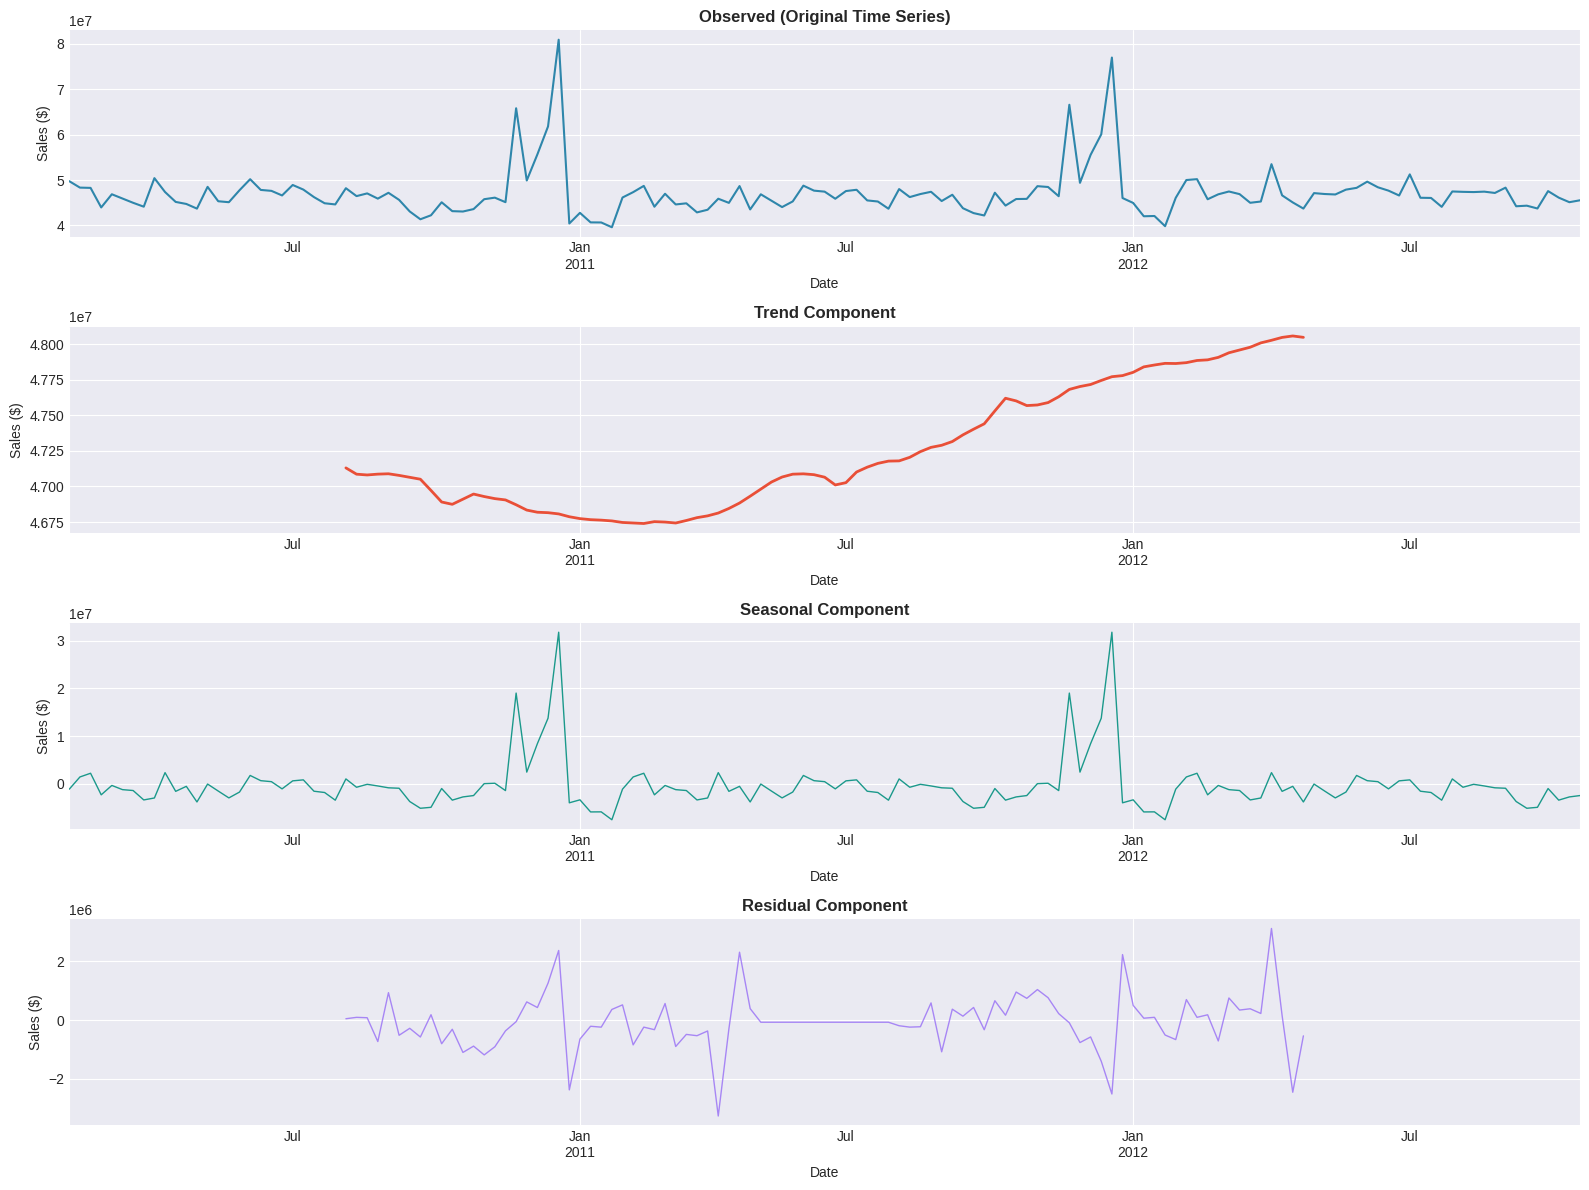

 Time series decomposition completed!


In [ ]:
# CELL 10: Time Series Decomposition


# Prepare time series for decomposition
ts_data = weekly_total.set_index('Date')['Total_Sales']

# Decompose (assuming weekly seasonality period ~52 weeks for annual, use 4 for monthly pattern)
try:
    decomposition = seasonal_decompose(ts_data, model='additive', period=52)

    fig, axes = plt.subplots(4, 1, figsize=(16, 12))

    decomposition.observed.plot(ax=axes[0], color='#2E86AB', linewidth=1.5)
    axes[0].set_title('Observed (Original Time Series)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Sales ($)')

    decomposition.trend.plot(ax=axes[1], color='#E94F37', linewidth=2)
    axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Sales ($)')

    decomposition.seasonal.plot(ax=axes[2], color='#1B998B', linewidth=1)
    axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Sales ($)')

    decomposition.resid.plot(ax=axes[3], color='#8B5CF6', linewidth=1, alpha=0.7)
    axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
    axes[3].set_ylabel('Sales ($)')

    plt.tight_layout()
    plt.savefig('walmart_decomposition.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(" Time series decomposition completed!")

except Exception as e:
    print(f" Decomposition skipped (need more data): {e}")

In [ ]:
# CELL 11: Prepare Data for Forecasting

# Use 80% for training, 20% for testing
train_size = int(len(weekly_total) * 0.8)
train_data = weekly_total[:train_size].copy()
test_data = weekly_total[train_size:].copy()

print(f"\n📊 DATA SPLIT FOR FORECASTING:")
print(f"   Training data: {len(train_data)} weeks ({train_data['Date'].min().date()} to {train_data['Date'].max().date()})")
print(f"   Testing data: {len(test_data)} weeks ({test_data['Date'].min().date()} to {test_data['Date'].max().date()})")

# Prepare time series
y_train = train_data['Total_Sales'].values
y_test = test_data['Total_Sales'].values



📊 DATA SPLIT FOR FORECASTING:
   Training data: 114 weeks (2010-02-05 to 2012-04-06)
   Testing data: 29 weeks (2012-04-13 to 2012-10-26)


In [ ]:
# CELL 12: Model 1 - ARIMA with Auto-Selection


print("\ Finding optimal ARIMA parameters using auto_arima...")
print(" This may take 2-3 minutes...")

# Auto ARIMA to find best parameters
auto_model = auto_arima(y_train,
                        start_p=0, start_q=0,
                        max_p=5, max_q=5, max_d=2,
                        seasonal=False,  # Will try SARIMA separately
                        stepwise=True,
                        suppress_warnings=True,
                        error_action='ignore',
                        trace=False,
                        n_fits=50)

print(f" Best ARIMA model found: ARIMA{auto_model.order}")
print("\n Model Summary:")
print(auto_model.summary())

# Fit final ARIMA model
arima_model = ARIMA(y_train, order=auto_model.order)
arima_fitted = arima_model.fit()

# Forecast
arima_forecast = arima_fitted.forecast(steps=len(test_data))

# Get confidence intervals
arima_conf = arima_fitted.get_forecast(steps=len(test_data))
arima_conf_int = arima_conf.conf_int()

# Calculate metrics
arima_mae = mean_absolute_error(y_test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast))
arima_mape = mean_absolute_percentage_error(y_test, arima_forecast) * 100

print(f"\n ARIMA{auto_model.order} Model Performance:")
print(f"   MAE:  ${arima_mae:,.0f}")
print(f"   RMSE: ${arima_rmse:,.0f}")
print(f"   MAPE: {arima_mape:.2f}%")

\ Finding optimal ARIMA parameters using auto_arima...
 This may take 2-3 minutes...
 Best ARIMA model found: ARIMA(5, 0, 0)

 Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1922.810
Date:                Thu, 27 Nov 2025   AIC                           3859.621
Time:                        17:57:41   BIC                           3878.774
Sample:                             0   HQIC                          3867.394
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.349e+07   5.29e-10   6.33e+16      0.000    3.35e+07  

In [ ]:

# CELL 13: Model 2 - SARIMA (Seasonal ARIMA)

print("\nTraining SARIMA model (with seasonality)...")

sarima_available = False # Initialize sarima_available before the try block

try:
    # Try SARIMA with weekly seasonality (m=13 for quarterly)
    sarima_model = SARIMAX(y_train,
                          order=auto_model.order,
                          seasonal_order=(1, 1, 1, 13),  # Corrected to 13 weeks for quarterly seasonality
                          enforce_stationarity=False,
                          enforce_invertibility=False)
    sarima_fitted = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fitted.forecast(steps=len(test_data))

    # Calculate metrics
    sarima_mae = mean_absolute_error(y_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_forecast))
    sarima_mape = mean_absolute_percentage_error(y_test, sarima_forecast) * 100

    print(f" SARIMA model trained successfully!")
    print(f"\n SARIMA Model Performance:")
    print(f"   MAE:  ${sarima_mae:,.0f}")
    print(f"   RMSE: ${sarima_rmse:,.0f}")
    print(f"   MAPE: {sarima_mape:.2f}%")

    sarima_available = True

except Exception as e:
    print(f" SARIMA failed, using ARIMA only: {e}")
    sarima_forecast = arima_forecast
    sarima_mae, sarima_rmse, sarima_mape = arima_mae, arima_rmse, arima_mape
    sarima_available = False



Training SARIMA model (with seasonality)...
 SARIMA model trained successfully!

 SARIMA Model Performance:
   MAE:  $3,050,849
   RMSE: $4,628,975
   MAPE: 6.53%


In [ ]:
# CELL 14: Model 3 - Exponential Smoothing (Holt-Winters)

print("\n Training Exponential Smoothing model...")

try:
    # Holt-Winters with additive trend
    exp_model = ExponentialSmoothing(y_train,
                                      trend='add',
                                      seasonal='add',
                                      seasonal_periods=4)  # Quarterly
    exp_fitted = exp_model.fit()
    exp_forecast = exp_fitted.forecast(steps=len(test_data))

except Exception as e:
    print(f" Seasonal model failed, using additive trend only: {e}")
    exp_model = ExponentialSmoothing(y_train, trend='add', seasonal=None)
    exp_fitted = exp_model.fit()
    exp_forecast = exp_fitted.forecast(steps=len(test_data))

# Calculate metrics
exp_mae = mean_absolute_error(y_test, exp_forecast)
exp_rmse = np.sqrt(mean_squared_error(y_test, exp_forecast))
exp_mape = mean_absolute_percentage_error(y_test, exp_forecast) * 100

print(f" Exponential Smoothing model trained!")
print(f"\n Exponential Smoothing Performance:")
print(f"   MAE:  ${exp_mae:,.0f}")
print(f"   RMSE: ${exp_rmse:,.0f}")
print(f"   MAPE: {exp_mape:.2f}%")


 Training Exponential Smoothing model...
 Exponential Smoothing model trained!

 Exponential Smoothing Performance:
   MAE:  $2,357,700
   RMSE: $3,008,824
   MAPE: 5.14%


In [ ]:
# CELL 15: Model 4 - Random Forest with Features


print("\n Training Random Forest model with external features...")

# Prepare features for ML model
feature_cols = ['IsHoliday', 'Avg_Temperature', 'Avg_Fuel_Price', 'Avg_CPI',
                'Avg_Unemployment', 'Total_MarkDown', 'Week', 'Month']

X_train_rf = train_data[feature_cols].copy()
X_test_rf = test_data[feature_cols].copy()

# Convert boolean to int
X_train_rf['IsHoliday'] = X_train_rf['IsHoliday'].astype(int)
X_test_rf['IsHoliday'] = X_test_rf['IsHoliday'].astype(int)

# Fill any missing values
X_train_rf = X_train_rf.fillna(X_train_rf.median())
X_test_rf = X_test_rf.fillna(X_train_rf.median())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rf)
X_test_scaled = scaler.transform(X_test_rf)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict
rf_forecast = rf_model.predict(X_test_scaled)

# Calculate metrics
rf_mae = mean_absolute_error(y_test, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_forecast))
rf_mape = mean_absolute_percentage_error(y_test, rf_forecast) * 100

print(f" Random Forest model trained!")
print(f"\n Random Forest Performance:")
print(f"   MAE:  ${rf_mae:,.0f}")
print(f"   RMSE: ${rf_rmse:,.0f}")
print(f"   MAPE: {rf_mape:.2f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Feature Importance:")
print(feature_importance.to_string(index=False))


 Training Random Forest model with external features...
 Random Forest model trained!

 Random Forest Performance:
   MAE:  $3,842,749
   RMSE: $4,128,991
   MAPE: 8.35%

 Feature Importance:
         Feature  Importance
            Week    0.615145
 Avg_Temperature    0.128654
Avg_Unemployment    0.089992
  Avg_Fuel_Price    0.054602
           Month    0.041495
         Avg_CPI    0.031116
  Total_MarkDown    0.027985
       IsHoliday    0.011011


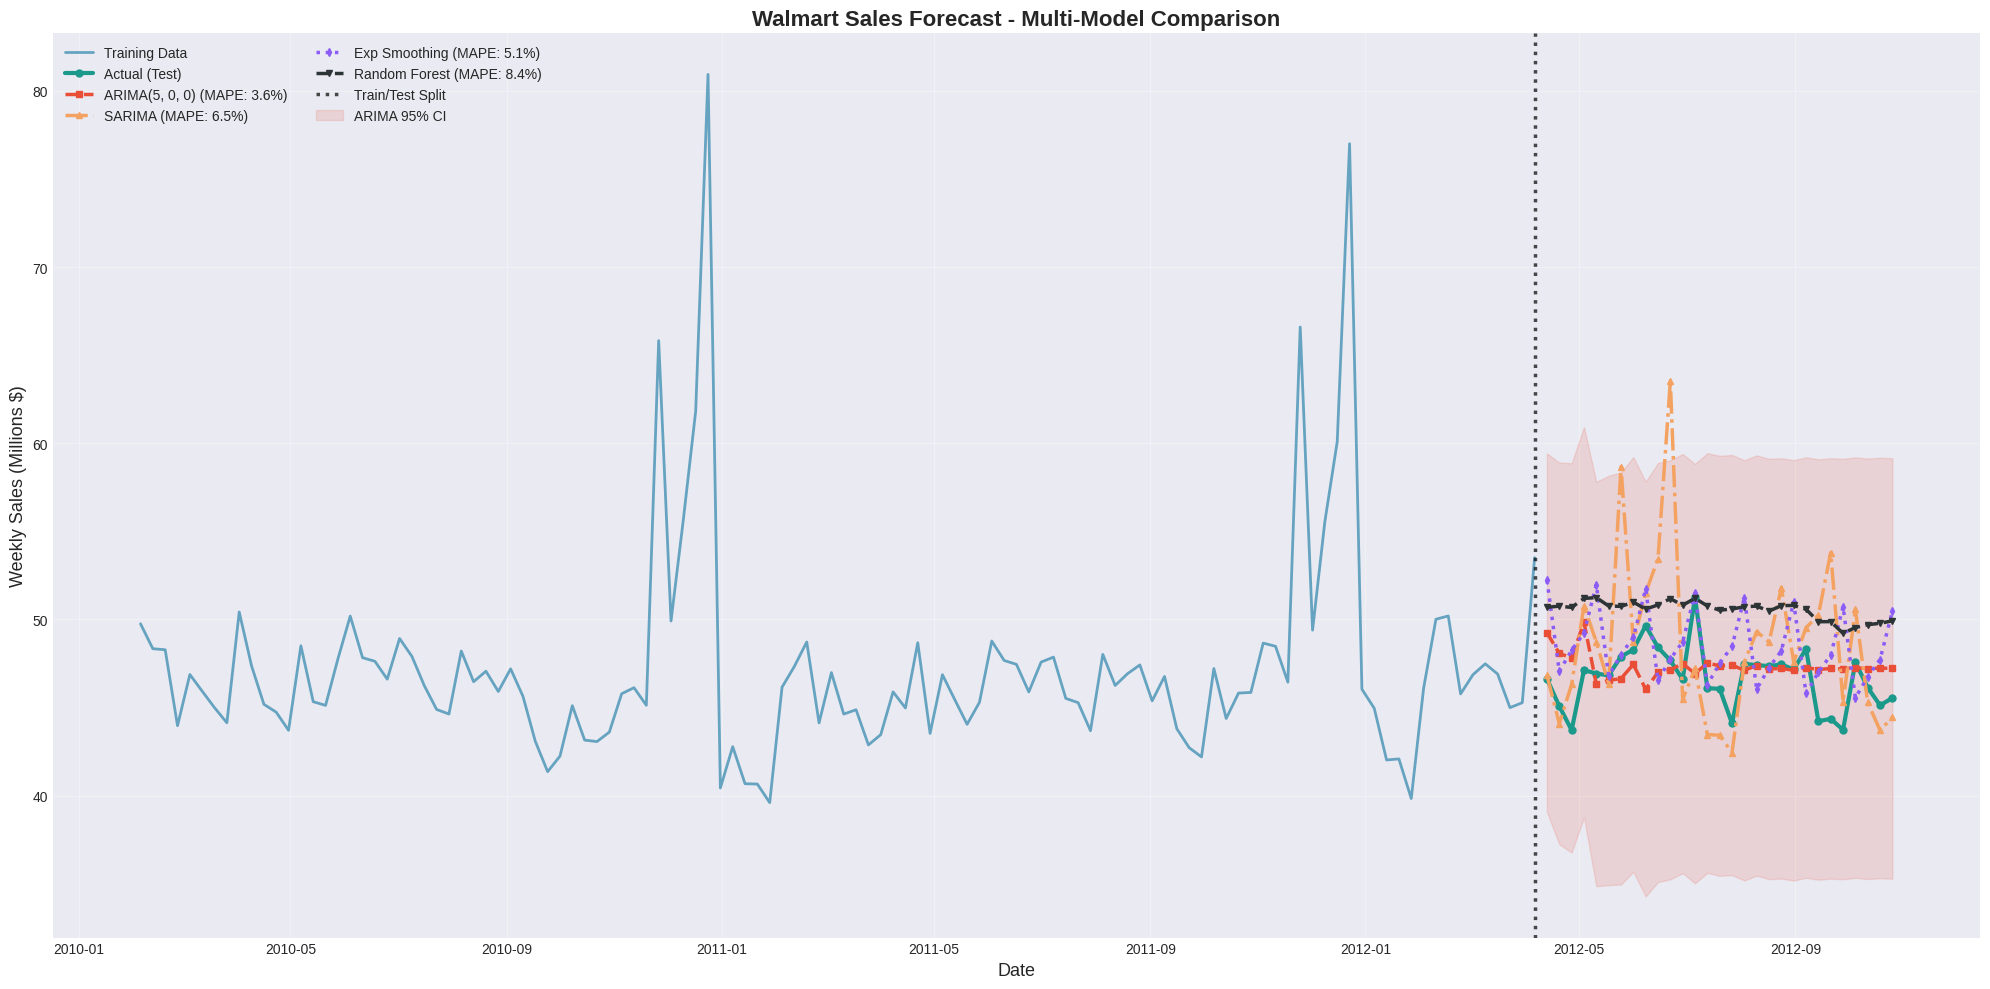

 Forecast comparison saved: walmart_forecast_comparison.png


In [ ]:
# CELL 16: Visualization - Forecast Comparison


plt.figure(figsize=(20, 10))

# Plot training data
plt.plot(train_data['Date'], y_train/1e6, label='Training Data',
         color='#2E86AB', linewidth=2, alpha=0.7)

# Plot actual test data
plt.plot(test_data['Date'], y_test/1e6, label='Actual (Test)',
         color='#1B998B', linewidth=3, marker='o', markersize=5)

# Plot forecasts
plt.plot(test_data['Date'], arima_forecast/1e6,
         label=f'ARIMA{auto_model.order} (MAPE: {arima_mape:.1f}%)',
         color='#E94F37', linewidth=2.5, linestyle='--', marker='s', markersize=4)

if sarima_available:
    plt.plot(test_data['Date'], sarima_forecast/1e6,
             label=f'SARIMA (MAPE: {sarima_mape:.1f}%)',
             color='#F4A261', linewidth=2.5, linestyle='-.', marker='^', markersize=4)

plt.plot(test_data['Date'], exp_forecast/1e6,
         label=f'Exp Smoothing (MAPE: {exp_mape:.1f}%)',
         color='#8B5CF6', linewidth=2.5, linestyle=':', marker='d', markersize=4)

plt.plot(test_data['Date'], rf_forecast/1e6,
         label=f'Random Forest (MAPE: {rf_mape:.1f}%)',
         color='#2D3436', linewidth=2.5, linestyle='--', marker='v', markersize=4)

# Add vertical line at train/test split
plt.axvline(x=train_data['Date'].iloc[-1], color='black',
            linestyle=':', linewidth=2.5, alpha=0.7, label='Train/Test Split')

# Confidence interval for ARIMA
plt.fill_between(test_data['Date'],
                 arima_conf_int[:, 0]/1e6,
                 arima_conf_int[:, 1]/1e6,
                 alpha=0.15, color='#E94F37', label='ARIMA 95% CI')

plt.title('Walmart Sales Forecast - Multi-Model Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Weekly Sales (Millions $)', fontsize=13)
plt.legend(fontsize=10, loc='upper left', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('walmart_forecast_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Forecast comparison saved: walmart_forecast_comparison.png")

In [ ]:
# CELL 17: Model Comparison Summary


comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Exponential Smoothing', 'Random Forest'],
    'MAE ($)': [f'{arima_mae:,.0f}', f'{sarima_mae:,.0f}', f'{exp_mae:,.0f}', f'{rf_mae:,.0f}'],
    'RMSE ($)': [f'{arima_rmse:,.0f}', f'{sarima_rmse:,.0f}', f'{exp_rmse:,.0f}', f'{rf_rmse:,.0f}'],
    'MAPE (%)': [f'{arima_mape:.2f}', f'{sarima_mape:.2f}', f'{exp_mape:.2f}', f'{rf_mape:.2f}']
})

print("\n" + "="*80)
print("MODEL COMPARISON - WALMART SALES FORECAST ACCURACY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
mape_values = {'ARIMA': arima_mape, 'SARIMA': sarima_mape,
               'Exponential Smoothing': exp_mape, 'Random Forest': rf_mape}
best_model_name = min(mape_values, key=mape_values.get)
best_mape = mape_values[best_model_name]

print(f"\n BEST MODEL: {best_model_name} with MAPE of {best_mape:.2f}%")

if best_mape < 5:
    print(" Excellent forecast accuracy!")
elif best_mape < 10:
    print("Very good forecast accuracy - suitable for operational planning")
elif best_mape < 15:
    print("Good forecast accuracy - recommended for inventory planning")
elif best_mape < 25:
    print(" Moderate accuracy - use with caution for critical decisions")
else:
    print(" Consider additional feature engineering or alternative approaches")




MODEL COMPARISON - WALMART SALES FORECAST ACCURACY
                Model   MAE ($)  RMSE ($) MAPE (%)
                ARIMA 1,673,743 2,123,958     3.62
               SARIMA 3,050,849 4,628,975     6.53
Exponential Smoothing 2,357,700 3,008,824     5.14
        Random Forest 3,842,749 4,128,991     8.35

 BEST MODEL: ARIMA with MAPE of 3.62%
 Excellent forecast accuracy!


In [ ]:
# CELL 18: Future Forecast (Next 12 Weeks)

print("\n Generating 12-week future forecast using full dataset...")

# Use full dataset for final model
full_sales = weekly_total['Total_Sales'].values

# Refit best model on full data
if best_model_name in ['ARIMA', 'SARIMA']:
    final_model = ARIMA(full_sales, order=auto_model.order)
    final_fitted = final_model.fit()

    # Forecast
    forecast_steps = 12
    future_forecast = final_fitted.forecast(steps=forecast_steps)
    future_conf = final_fitted.get_forecast(steps=forecast_steps)
    future_conf_int = future_conf.conf_int()

else:  # Use ARIMA as default for future forecast
    final_model = ARIMA(full_sales, order=auto_model.order)
    final_fitted = final_model.fit()
    forecast_steps = 12
    future_forecast = final_fitted.forecast(steps=forecast_steps)
    future_conf = final_fitted.get_forecast(steps=forecast_steps)
    future_conf_int = future_conf.conf_int()

# Create future dates
last_date = weekly_total['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(weeks=1), periods=forecast_steps, freq='W')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Week_Starting': future_dates,
    'Predicted_Sales': future_forecast.round(0).astype(int),
    'Lower_CI_95%': future_conf_int[:, 0].round(0).astype(int),
    'Upper_CI_95%': future_conf_int[:, 1].round(0).astype(int)
})

# Add inventory simulation
avg_weekly_sales = weekly_total['Total_Sales'].mean()
forecast_df['Inventory_Change'] = -forecast_df['Predicted_Sales'] / 1e6 + (avg_weekly_sales * 1.05) / 1e6
last_inventory = weekly_total['Inventory_Level'].iloc[-1]
forecast_df['Projected_Inventory'] = last_inventory + forecast_df['Inventory_Change'].cumsum()

# Add status
MAX_INVENTORY = 80  # Maximum warehouse capacity in millions
forecast_df['Inventory_%'] = (forecast_df['Projected_Inventory'] / MAX_INVENTORY * 100).round(1)
forecast_df['Status'] = forecast_df['Inventory_%'].apply(
    lambda x: '🟢 OK' if x < 75 else ('🟡 HIGH' if x < 90 else '🔴 CRITICAL')
)

print("\n" + "="*100)
print("12-WEEK WALMART SALES & INVENTORY FORECAST")
print("="*100)
print(forecast_df[['Week_Starting', 'Predicted_Sales', 'Lower_CI_95%', 'Upper_CI_95%',
                   'Projected_Inventory', 'Inventory_%', 'Status']].to_string(index=False))
print("="*100)

# Summary stats
print(f"\n FORECAST SUMMARY:")
print(f"   Total Predicted Sales (12 weeks): ${forecast_df['Predicted_Sales'].sum():,.0f}")
print(f"   Average Weekly Prediction: ${forecast_df['Predicted_Sales'].mean():,.0f}")
print(f"   Final Projected Inventory: {forecast_df['Projected_Inventory'].iloc[-1]:.2f}M units")



 Generating 12-week future forecast using full dataset...

12-WEEK WALMART SALES & INVENTORY FORECAST
Week_Starting  Predicted_Sales  Lower_CI_95%  Upper_CI_95%  Projected_Inventory  Inventory_%     Status
   2012-11-04         47813171      38629024      56997319           668.598425        835.7 🔴 CRITICAL
   2012-11-11         46894863      37119033      56670694           671.172652        839.0 🔴 CRITICAL
   2012-11-18         46989151      37022760      56955541           673.652591        842.1 🔴 CRITICAL
   2012-11-25         47347516      37363757      57331275           675.774166        844.7 🔴 CRITICAL
   2012-12-02         47973381      37634284      58312478           677.269875        846.6 🔴 CRITICAL
   2012-12-09         47129842      36668054      57591630           679.609124        849.5 🔴 CRITICAL
   2012-12-16         47225535      36702680      57748390           681.852679        852.3 🔴 CRITICAL
   2012-12-23         47229200      36636087      57822312       

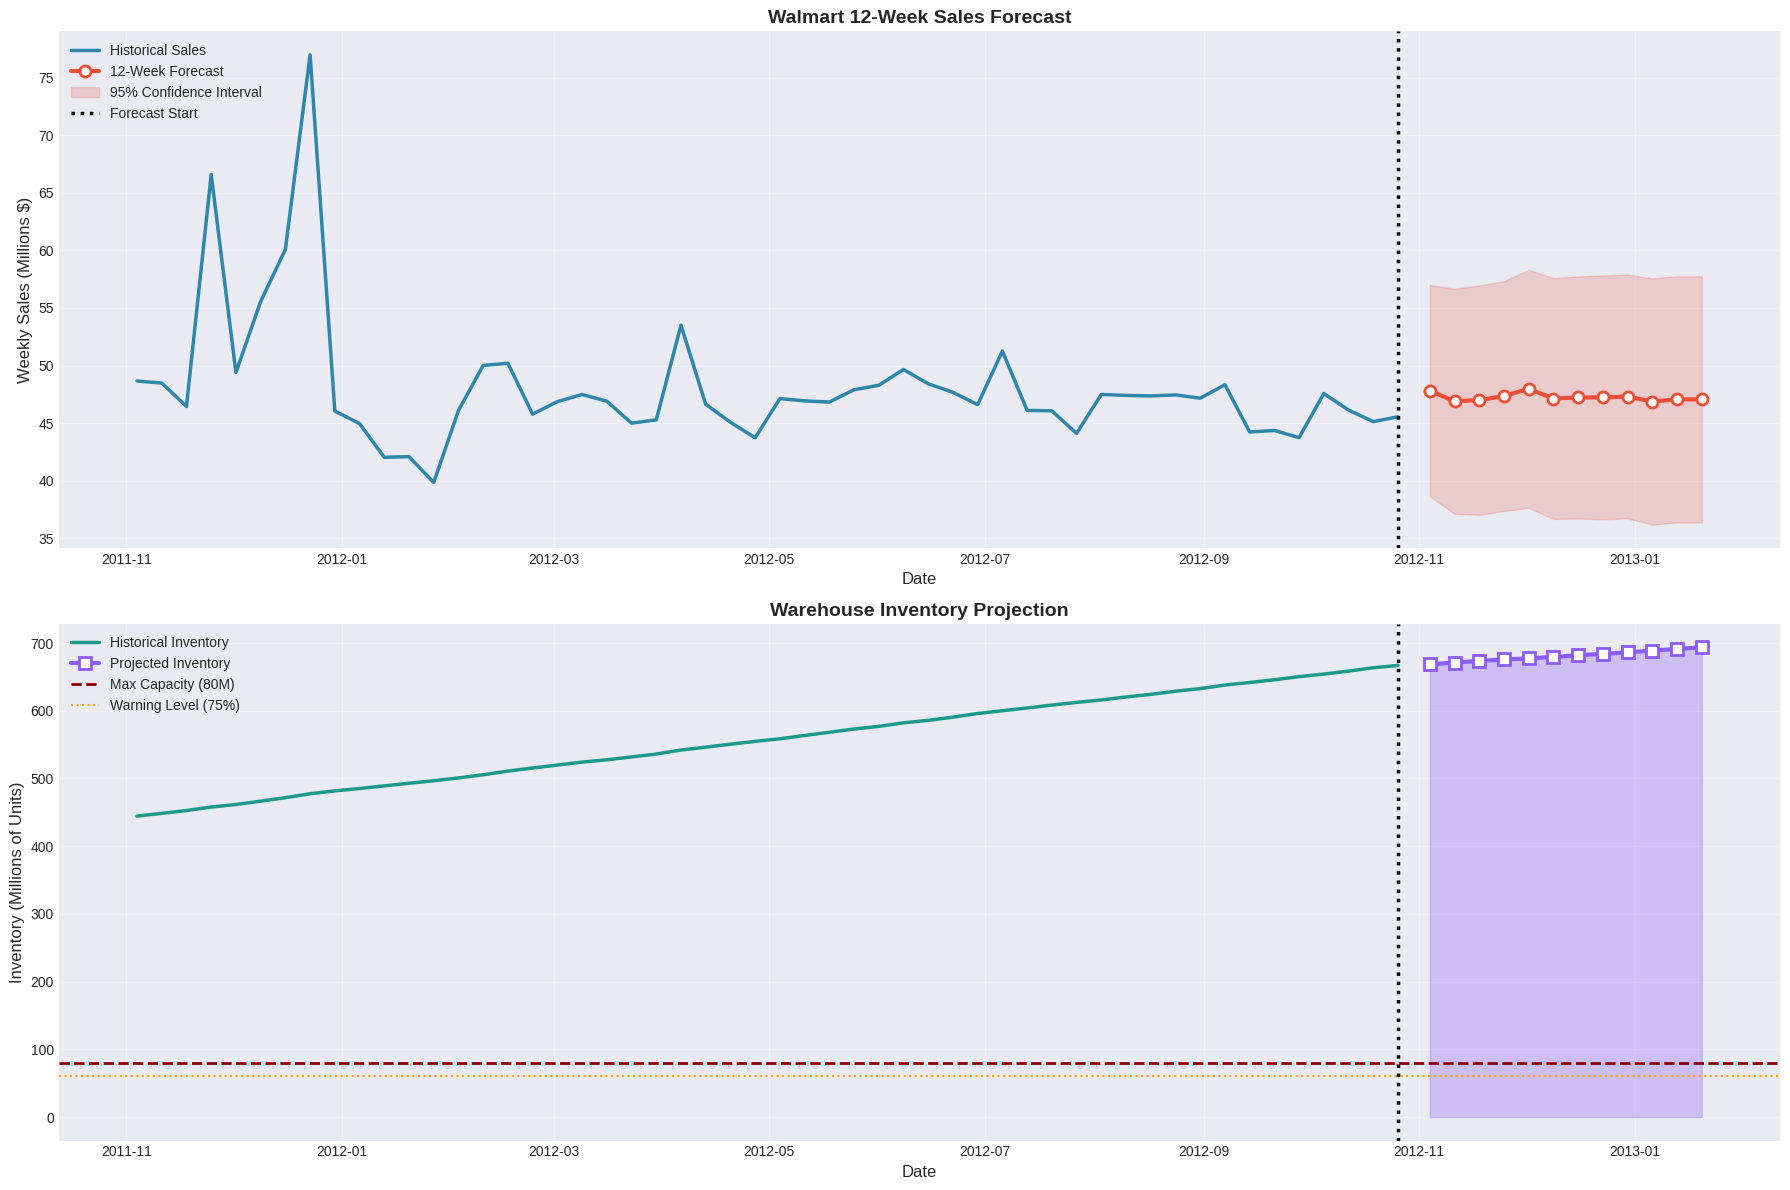

 Future forecast visualization saved: walmart_future_forecast.png


In [ ]:
# CELL 19: Visualize Future Forecast
#

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Plot 1: Sales Forecast
lookback_weeks = min(52, len(weekly_total))
recent_data = weekly_total.tail(lookback_weeks)

axes[0].plot(recent_data['Date'], recent_data['Total_Sales']/1e6,
             label='Historical Sales', color='#2E86AB', linewidth=2.5)
axes[0].plot(forecast_df['Week_Starting'], forecast_df['Predicted_Sales']/1e6,
             label='12-Week Forecast', color='#E94F37', linewidth=3,
             marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2)
axes[0].fill_between(forecast_df['Week_Starting'],
                     forecast_df['Lower_CI_95%']/1e6,
                     forecast_df['Upper_CI_95%']/1e6,
                     alpha=0.2, color='#E94F37', label='95% Confidence Interval')
axes[0].axvline(x=weekly_total['Date'].iloc[-1], color='black',
                linestyle=':', linewidth=2.5, label='Forecast Start')
axes[0].set_title('Walmart 12-Week Sales Forecast', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Weekly Sales (Millions $)', fontsize=12)
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Inventory Projection
axes[1].plot(recent_data['Date'], recent_data['Inventory_Level'],
             label='Historical Inventory', color='#1B998B', linewidth=2.5)
axes[1].plot(forecast_df['Week_Starting'], forecast_df['Projected_Inventory'],
             label='Projected Inventory', color='#8B5CF6', linewidth=3,
             marker='s', markersize=8, markerfacecolor='white', markeredgewidth=2)
axes[1].axhline(y=MAX_INVENTORY, color='darkred', linestyle='--', linewidth=2,
                label=f'Max Capacity ({MAX_INVENTORY}M)')
axes[1].axhline(y=MAX_INVENTORY * 0.75, color='orange', linestyle=':', linewidth=1.5,
                label='Warning Level (75%)')
axes[1].axvline(x=weekly_total['Date'].iloc[-1], color='black',
                linestyle=':', linewidth=2.5)
axes[1].fill_between(forecast_df['Week_Starting'], 0, forecast_df['Projected_Inventory'],
                     alpha=0.3, color='#8B5CF6')
axes[1].set_title('Warehouse Inventory Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Inventory (Millions of Units)', fontsize=12)
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walmart_future_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Future forecast visualization saved: walmart_future_forecast.png")


 Generating forecasts for Top 5 stores...
 Generated forecasts for 5 stores


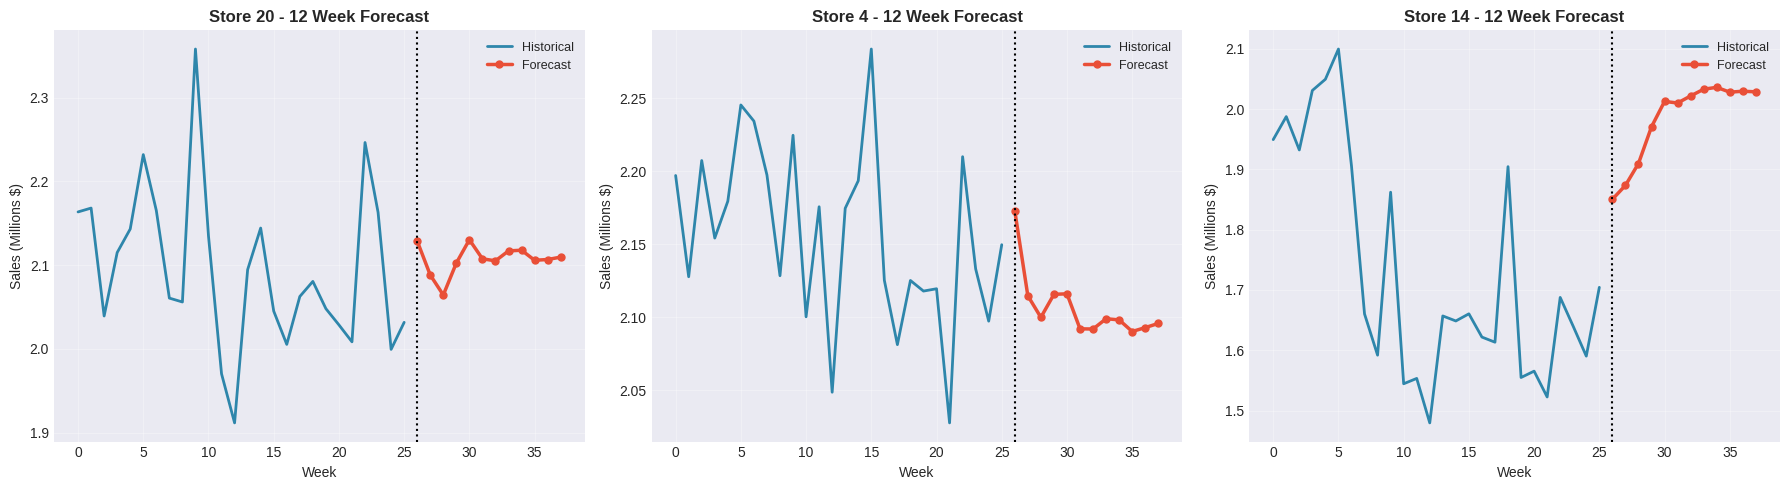

 Store-level forecasts saved: walmart_store_forecasts.png


In [ ]:
# CELL 20: Store-Level Forecasting (Top 5 Stores)

print("\n Generating forecasts for Top 5 stores...")

top_5_stores = store_summary.head(5)['Store'].values

store_forecasts = {}

for store_id in top_5_stores:
    store_data = df[df['Store'] == store_id].groupby('Date')['Weekly_Sales'].sum().reset_index()
    store_data = store_data.sort_values('Date')

    if len(store_data) >= 20:  # Need enough data
        store_sales = store_data['Weekly_Sales'].values

        try:
            store_model = ARIMA(store_sales, order=auto_model.order)
            store_fitted = store_model.fit()
            store_forecast = store_fitted.forecast(steps=12)
            store_forecasts[store_id] = {
                'historical': store_sales,
                'forecast': store_forecast,
                'dates': store_data['Date'].values
            }
        except:
            pass

print(f" Generated forecasts for {len(store_forecasts)} stores")

# Visualize top store forecasts
if len(store_forecasts) >= 3:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (store_id, data) in enumerate(list(store_forecasts.items())[:3]):
        ax = axes[idx]

        # Last 26 weeks of history
        hist_len = min(26, len(data['historical']))
        ax.plot(range(hist_len), data['historical'][-hist_len:]/1e6,
                label='Historical', color='#2E86AB', linewidth=2)
        ax.plot(range(hist_len, hist_len + 12), data['forecast']/1e6,
                label='Forecast', color='#E94F37', linewidth=2.5,
                marker='o', markersize=5)
        ax.axvline(x=hist_len, color='black', linestyle=':', linewidth=1.5)
        ax.set_title(f'Store {store_id} - 12 Week Forecast', fontsize=12, fontweight='bold')
        ax.set_xlabel('Week')
        ax.set_ylabel('Sales (Millions $)')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('walmart_store_forecasts.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(" Store-level forecasts saved: walmart_store_forecasts.png")

In [ ]:
# CELL 21: Export Results

# Export weekly aggregated data
weekly_total.to_csv('walmart_weekly_aggregated.csv', index=False)
print(" Exported: walmart_weekly_aggregated.csv")

# Export forecast
forecast_df.to_csv('walmart_12week_forecast.csv', index=False)
print(" Exported: walmart_12week_forecast.csv")

# Export model comparison
comparison_df.to_csv('walmart_model_comparison.csv', index=False)
print("Exported: walmart_model_comparison.csv")

# Export store summary
store_summary.to_csv('walmart_store_summary.csv', index=False)
print(" Exported: walmart_store_summary.csv")

# Export feature importance
feature_importance.to_csv('walmart_feature_importance.csv', index=False)
print(" Exported: walmart_feature_importance.csv")

print("\n All results exported successfully!")

 Exported: walmart_weekly_aggregated.csv
 Exported: walmart_12week_forecast.csv
Exported: walmart_model_comparison.csv
 Exported: walmart_store_summary.csv
 Exported: walmart_feature_importance.csv

 All results exported successfully!


In [ ]:
# CELL 22: Final Summary Report

print("\n" + "="*80)
print("PROJECT SUMMARY - WALMART SALES FORECASTING & INVENTORY OPTIMIZATION")
print("="*80)
print(f" Dataset Source: Kaggle - Walmart Store Sales Forecasting Competition")
print(f" Date Range: {weekly_total['Date'].min().date()} to {weekly_total['Date'].max().date()}")
print(f" Total Weeks: {len(weekly_total)}")
print(f" Total Stores: {df['Store'].nunique()}")
print(f" Total Departments: {df['Dept'].nunique()}")
print(f" Total Sales: ${df['Weekly_Sales'].sum():,.0f}")
print(f" Average Weekly Sales: ${weekly_total['Total_Sales'].mean():,.0f}")
print(f" Holiday Week Premium: +{(holiday_comparison['mean'].iloc[1] - holiday_comparison['mean'].iloc[0]) / holiday_comparison['mean'].iloc[0] * 100:.1f}%")
print()
print(f" FORECASTING RESULTS:")
print(f"   Best Model: {best_model_name}")
print(f"   Model Parameters: ARIMA{auto_model.order}")
print(f"   Forecast Accuracy (MAPE): {best_mape:.2f}%")
print(f"   Forecast Horizon: 12 weeks")
print(f"   12-Week Total Prediction: ${forecast_df['Predicted_Sales'].sum():,.0f}")
print()
print(f" INVENTORY INSIGHTS:")
print(f"   Current Inventory Level: {weekly_total['Inventory_Level'].iloc[-1]:.2f}M units")
print(f"   Projected Level (12 weeks): {forecast_df['Projected_Inventory'].iloc[-1]:.2f}M units")
print(f"   Warehouse Capacity: {MAX_INVENTORY}M units")
print()
print(f" TOP PREDICTIVE FEATURES:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.3f}")
print()
print(f" EXPORTED FILES:")
print(f"   - walmart_weekly_aggregated.csv")
print(f"   - walmart_12week_forecast.csv")
print(f"   - walmart_model_comparison.csv")
print(f"   - walmart_store_summary.csv")
print(f"   - walmart_feature_importance.csv")
print(f"   - walmart_time_series_analysis.png")
print(f"   - walmart_seasonal_analysis.png")
print(f"   - walmart_forecast_comparison.png")
print(f"   - walmart_future_forecast.png")




PROJECT SUMMARY - WALMART SALES FORECASTING & INVENTORY OPTIMIZATION
 Dataset Source: Kaggle - Walmart Store Sales Forecasting Competition
 Date Range: 2010-02-05 to 2012-10-26
 Total Weeks: 143
 Total Stores: 45
 Total Departments: 81
 Total Sales: $6,737,218,987
 Average Weekly Sales: $47,113,419
 Holiday Week Premium: +7.8%

 FORECASTING RESULTS:
   Best Model: ARIMA
   Model Parameters: ARIMA(5, 0, 0)
   Forecast Accuracy (MAPE): 3.62%
   Forecast Horizon: 12 weeks
   12-Week Total Prediction: $566,894,039

 INVENTORY INSIGHTS:
   Current Inventory Level: 666.94M units
   Projected Level (12 weeks): 693.68M units
   Warehouse Capacity: 80M units

 TOP PREDICTIVE FEATURES:
   7. Week: 0.615
   2. Avg_Temperature: 0.129
   5. Avg_Unemployment: 0.090

 EXPORTED FILES:
   - walmart_weekly_aggregated.csv
   - walmart_12week_forecast.csv
   - walmart_model_comparison.csv
   - walmart_store_summary.csv
   - walmart_feature_importance.csv
   - walmart_time_series_analysis.png
   - walmart